## FWF and point cloud data alignment

*Align each pulse in the PulseWaves file with its returns in the point cloud file*

### Preparation

Fetch the data from the SDR if you do not have them locally. Otherwise, set the local file pathss in the next code block.

In [1]:
project='d15' # project name, 'd15' for Dublin 2015 or 'sp19' for Sunset Park 2019
line='115601' # flight line number, get from the index map or the bitstreams.json or the meta.json files

# fetch point cloud
!../scripts/fetch.sh $project $line pc

# fetch pulsewaves
!../scripts/fetch.sh $project $line fwf-pw

# convert a segment of the pulsewaves file to pwmsg format
!mkdir -p ../data/pwmsg
!java -jar "../jar/umg-cli-0.2.0-SNAPSHOT-jar-with-dependencies.jar" pw2proto -idir ../data/fwf-pw -odir ../data/pwmsg -meta_file ../data/metadata/$project-meta.json -segment 100000 -subseq 0 5000

--2020-08-01 10:07:42--  https://archive.nyu.edu/retrieve/79993/nyu_2451_38625_pc_F_150326_115601.zip
Resolving archive.nyu.edu (archive.nyu.edu)... 128.122.108.142
Connecting to archive.nyu.edu (archive.nyu.edu)|128.122.108.142|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 89911675 (86M) [application/octet-stream]
Saving to: ‘tmp1596272862.20098/nyu_2451_38625_pc_F_150326_115601.zip’

nyu_2451_38625_pc_F 100%[===================>]  85.75M  13.6MB/s    in 6.7s    

2020-08-01 10:07:51 (12.8 MB/s) - ‘tmp1596272862.20098/nyu_2451_38625_pc_F_150326_115601.zip’ saved [89911675/89911675]

Archive:  tmp1596272862.20098/nyu_2451_38625_pc_F_150326_115601.zip
   creating: tmp1596272862.20098/nyu_2451_38625_laz/
  inflating: tmp1596272862.20098/nyu_2451_38625_laz/F_150326_115601.laz  
moving tmp1596272862.20098/nyu_2451_38625_laz/F_150326_115601.laz to ../data/pc-laz
Check /home/vvo/code/vvogit/sunsetpark/data/pc-laz 

The paths below must be set manually.

In [2]:
# pulsewaves file
plswvs_fname = '../data/fwf-pw/F_150326_115601.pls'

# pwmsg file
pwmsg_fname = '../data/pwmsg/F_150326_115601-0.pwmsg'

# point cloud file
pc_fname = '../data/pc-laz/F_150326_115601.laz'

# check if the paths are valid
!ls $plswvs_fname
!ls $pwmsg_fname
!ls $pc_fname

../data/fwf-pw/F_150326_115601.pls
../data/pwmsg/F_150326_115601-0.pwmsg
../data/pc-laz/F_150326_115601.laz


Dependencies

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from laspy.file import File
import pypwaves.base as pypwaves

from als.pulsewaves import PulseWaves
from als.mess import get_points_by_time_brute_force as get_points

from datetime import datetime
from als.base import GPSTimeUtil
timeutil = GPSTimeUtil(flight_date = datetime(2015,3,26))

### Data parsing

Data parsing is required only once. This does not need to be rerun for each pulse index.

In [4]:
pw = PulseWaves(pwmsg_fname)
ppw = pypwaves.openPLS(plswvs_fname)
pcloud = File(pc_fname, mode = "r")

### Pulse index

Change the pusle index and run the subsequent code blocks to observe the pulse

In [5]:
pls_idx = 0

### The pulse in the PWMsg file

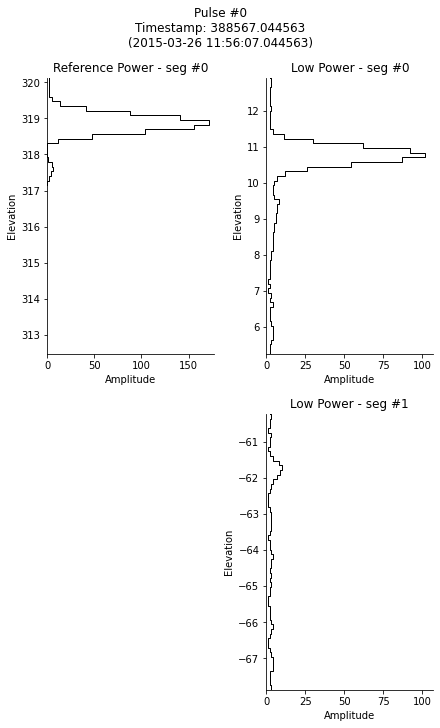

In [6]:
# get the pulse given the index
pulse = pw.get_pulse(pls_idx)

# compute the timestamp of the pulse to match with the point cloud returns
timestamp = pulse.timestamp * pw.scale.loc['t']['scale'] + pw.scale.loc['t']['offset']

# plot the waves
fig, axes = pw.plot_waves(pulse, title = 'Pulse #{}\nTimestamp: {}\n({})'.format(pls_idx, timestamp, timeutil.gpstime_to_datetime(timestamp)))

### The pulse in the PulseWaves file

To double check the waves seen in the PWMsg file, look at the waves as parsed using [PyPWaves](pypwaves).

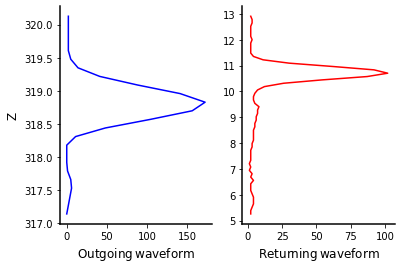

In [7]:
waves = ppw.get_waves(pulse_record = pls_idx)
waves.plot()

The waves parsed by PWMsg and PyPWaves match. The only difference is that PyWaves does not show all the segments and channels.

### The corresponding returns

Retrieve the returns in the point cloud that match the pulse's timestamp

In [8]:
# get the points given a timestamp
pts = get_points(pcloud, timestamp)
print('number of points found: {}'.format(len(pts)))

# format the points and print them
pts['intensity'] = pts['point'].apply(lambda _:_.intensity)
pts['return_num'] = pts['point'].apply(lambda _:_.return_num)
pts['num_returns'] = pts['point'].apply(lambda _:_.num_returns)
pts['timestamp'] = pts['point'].apply(lambda _:_.gps_time)
pts

number of points found: 2


,point,x,y,z,intensity,return_num,num_returns,timestamp
0,<laspy.util.Point object at 0x7faea0b15898>,315459.722,233580.778,-61.811,8,2,2,388567.044563
13291790,<laspy.util.Point object at 0x7faea0b152e8>,315434.282,233547.335,10.737,103,1,2,388567.044563


### Conclusion

The alignment is clear for most of the pulses when looking at the elevation (z) values.